In [1]:
from tianshou.env.pettingzoo_env import PettingZooEnv

import os
import gymnasium as gym
import numpy as np
import torch

import time

%reload_ext autoreload
%autoreload 2

/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [2]:
from gym_multi_car_racing import multi_car_racing_pyglet as multi_car_racing

n_agents = 2
# Step 1: Load the PettingZoo environment
env = multi_car_racing.env(n_agents=n_agents, direction="CCW", render_mode="human")

In [3]:
# Step 2: Wrap the environment for Tianshou interfacing
env = PettingZooEnv(env)

/home/developer/workspace/multi_car_racing/gym_multi_car_racing/multi_car_racing_pyglet.py:674: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')


In [4]:
from tianshou.env import DummyVectorEnv
from tianshou.policy import MultiAgentPolicyManager, RandomPolicy

# Step 3: Define policies for each agent
policies = MultiAgentPolicyManager([RandomPolicy() for _ in range(n_agents)], env)

In [5]:
# Step 4: Convert the env to vector format
env = DummyVectorEnv([lambda: env])

In [6]:
from tianshou.data import Collector

# Step 5: Construct the Collector, which interfaces the policies with the vectorised environment
collector = Collector(policies, env)

/home/developer/workspace/multi_car_racing/gym_multi_car_racing/multi_car_racing_pyglet.py:674: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')


In [7]:
# Step 6: Execute the environment with the agents playing for 1 episode, and render a frame every 0.1 seconds
result = collector.collect(n_episode=1)

In [7]:
env.close()

In [3]:
from typing import Optional, Tuple

from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.env.pettingzoo_env import PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager, RandomPolicy
from tianshou.trainer import offpolicy_trainer
from tianshou.utils.net.common import Net

In [4]:
def _get_agents(
    agent_learn: Optional[BasePolicy] = None,
    agent_opponent: Optional[BasePolicy] = None,
    optim: Optional[torch.optim.Optimizer] = None,
) -> Tuple[BasePolicy, torch.optim.Optimizer, list]:
    env = _get_env()
    observation_space = (
        env.observation_space["observation"]
        if isinstance(env.observation_space, gym.spaces.Dict)
        else env.observation_space
    )
    if agent_learn is None:
        # model
        net = Net(
            state_shape=observation_space.shape or observation_space.n,
            action_shape=env.action_space.shape or env.action_space.n,
            hidden_sizes=[32, 32, 32, 32],
            device="cuda" if torch.cuda.is_available() else "cpu",
        ).to("cuda" if torch.cuda.is_available() else "cpu")
        if optim is None:
            optim = torch.optim.Adam(net.parameters(), lr=1e-4)
        agent_learn = DQNPolicy(
            model=net,
            optim=optim,
            discount_factor=0.9,
            estimation_step=3,
            target_update_freq=320,
        )

    if agent_opponent is None:
        agent_opponent = RandomPolicy()

    agents = [agent_opponent, agent_learn]
    policy = MultiAgentPolicyManager(agents, env)
    return policy, optim, env.agents

def _get_env():
    """This function is needed to provide callables for DummyVectorEnv."""
    env = multi_car_racing.env(n_agents=n_agents, direction="CCW", render_mode="human")
    return PettingZooEnv(env)

In [5]:
# ======== Step 1: Environment setup =========
train_envs = DummyVectorEnv([_get_env for _ in range(1)])
test_envs = DummyVectorEnv([_get_env for _ in range(1)])

# seed
seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

/home/developer/workspace/multi_car_racing/gym_multi_car_racing/multi_car_racing_pyglet.py:674: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')


[None]

In [6]:
# ======== Step 2: Agent setup =========
policy, optim, agents = _get_agents()

In [7]:
# ======== Step 3: Collector setup =========
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)
# policy.set_eps(1)
train_collector.collect(n_step=64 * 10)  # batch size * training_num

/home/developer/workspace/multi_car_racing/gym_multi_car_racing/multi_car_racing_pyglet.py:674: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')


{'n/ep': 0,
 'n/st': 640,
 'rews': array([], dtype=float64),
 'lens': array([], dtype=int64),
 'idxs': array([], dtype=int64),
 'rew': 0,
 'len': 0,
 'rew_std': 0,
 'len_std': 0}

In [8]:
# ======== Step 4: Callback functions setup =========
def save_best_fn(policy):
    model_save_path = os.path.join("log", "rps", "dqn", "policy.pth")
    os.makedirs(os.path.join("log", "rps", "dqn"), exist_ok=True)
    torch.save(policy.policies[agents[1]].state_dict(), model_save_path)

def stop_fn(mean_rewards):
    return mean_rewards >= 0.6

def train_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [9]:
# ======== Step 5: Run the trainer =========
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=50,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=10,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
)

# return result, policy.policies[agents[1]]
print(f"\n==========Result==========\n{result}")
print("\n(the trained policy can be accessed via policy.policies[agents[1]])")

Epoch #1:   5%|5         | 50/1000 [00:03<00:46, 20.28it/s, car_1/loss=19.726, env_step=50, len=0, n/ep=0, n/st=50, rew=0.00]/home/developer/workspace/multi_car_racing/gym_multi_car_racing/multi_car_racing_pyglet.py:674: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  arr = np.fromstring(image_data.get_data(), dtype=np.uint8, sep='')
Epoch #1: 1001it [00:56, 17.61it/s, car_1/loss=3.003, env_step=1000, len=0, n/ep=0, n/st=50, rew=0.00]                          


Epoch #1: test_reward: -58.249344 ± 20.330170, best_reward: -58.249344 ± 20.330170 in #1


Epoch #2: 1001it [00:54, 18.50it/s, car_1/loss=5.600, env_step=2000, len=0, n/ep=0, n/st=50, rew=0.00]                          


Epoch #2: test_reward: -100.060877 ± 0.032160, best_reward: -58.249344 ± 20.330170 in #1


Epoch #3: 1001it [00:55, 18.13it/s, car_1/loss=2.389, env_step=3000, len=2984, n/ep=0, n/st=50, rew=-100.05]                          


Epoch #3: test_reward: -57.044845 ± 33.788629, best_reward: -57.044845 ± 33.788629 in #3


Epoch #4: 1001it [00:55, 17.91it/s, car_1/loss=2.615, env_step=4000, len=1154, n/ep=0, n/st=50, rew=-120.62]                          


Epoch #4: test_reward: -57.412519 ± 26.506414, best_reward: -57.044845 ± 33.788629 in #3


Epoch #5: 1001it [00:57, 17.41it/s, car_1/loss=9.016, env_step=5000, len=1056, n/ep=0, n/st=50, rew=-79.57]                           


Epoch #5: test_reward: -61.369216 ± 29.536643, best_reward: -57.044845 ± 33.788629 in #3


Epoch #6: 1001it [00:56, 17.67it/s, car_1/loss=11.134, env_step=6000, len=798, n/ep=0, n/st=50, rew=-72.91]                          


KeyboardInterrupt: 

Test parallel environment:

In [5]:
from pettingzoo.test import api_test

if __name__ == "__main__":
    api_test(env, num_cycles=1_000_000)

Starting API test
Track generation: 1076..1354 -> 278-tiles track
Track generation: 1093..1370 -> 277-tiles track
Track generation: 1237..1552 -> 315-tiles track
Track generation: 943..1183 -> 240-tiles track


KeyboardInterrupt: 

In [8]:
env.close()

In [108]:
from supersuit import pettingzoo_env_to_vec_env_v1, frame_stack_v1, concat_vec_envs_v1

#env = frame_stack_v1(env, 4)
env = pettingzoo_env_to_vec_env_v1(env)
env = concat_vec_envs_v1(env, num_vec_envs=1, num_cpus=1, base_class='stable_baselines3')

AssertionError: pettingzoo_env_to_vec_env takes in a pettingzoo ParallelEnv. Can create a parallel_env with pistonball.parallel_env() or convert it from an AEC env with `from pettingzoo.utils.conversions import aec_to_parallel; aec_to_parallel(env)``

In [10]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

AssertionError: Your environment must inherit from the gymnasium.Env class cf. https://gymnasium.farama.org/api/env/

## Training

In [30]:
log_path = os.path.join("Training", "Logs")
# Define model

# Single input
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path, gamma=0.99)

# MultiInputPolicy since we now have multiple inputs (image and speed)
#model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log=log_path, gamma=0.98)

Using cuda device
Wrapping the env in a VecTransposeImage.


TypeError: 'NoneType' object is not iterable

In [20]:
model.learn(total_timesteps=5_000)

Track generation: 1110..1392 -> 282-tiles track


ValueError: could not broadcast input array from shape (2,96,96,3) into shape (96,96,3)

In [40]:
env.close()

In [ ]:
ppo_path = os.path.join("Training", "Saved Models", "PPO_Car_Racing_multi_input_500k")

In [ ]:
model.save(ppo_path)

In [ ]:
model = PPO.load(ppo_path, env)

Wrapping the env in a VecTransposeImage.


In [ ]:
training_log_path = os.path.join(log_path, 'PPO_16')

In [ ]:
training_log_path

'Training/Logs/PPO_16'

In [ ]:
!tensorboard --logdir=training_log_path

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `tensorboard --logdir=str(training_log_path)'


### Test model

In [ ]:
env = gym.make("MultiCarRacing-v0", num_agents=1, direction='CCW',
        use_random_direction=True, backwards_flag=True, h_ratio=0.25,
        use_ego_color=False)
#env = DummyVecEnv([lambda: env])

In [ ]:
evaluate_policy(model, env, n_eval_episodes=1, render=True)

/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/developer/.local/share/virtualenvs/workspace-LQiMqFvY/lib/python3.8/site-packages/stable_baselines3/common/vec_env/base_vec_env.py:208: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Track generation: 1013..1278 -> 265-tiles track
Track generation: 1027..1288 -> 261-tiles track


(-1.515151523053646, 0.0)

In [ ]:
# Alternative way of testing the model

episodes = 1

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0

    avg_time_per_step = []

    t0 = time.time()
    while not done:
        env.render()
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action) 
        score += reward if reward != -100 else 0

        # Time per step
        t1 = time.time()
        delta = t1 - t0
        t0 = t1
        avg_time_per_step.append(delta)
        print(f"Time per step: {delta:.5f}s", end="\r")

    print(f"Episode: {episode} Score: {score}")
    print(f"Average time per step: {np.mean(avg_time_per_step):.5f}s")

env.close()

Track generation: 1196..1499 -> 303-tiles track
Episode: 1 Score: [-33.77483444]
Average time per step: 0.05716s


## Modifying the environment

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
environment_name = "CarRacing-v2"
env = gym.make(environment_name, render_mode="human")
env = DummyVecEnv([lambda: env])

In [ ]:
env.action_space.sample()

array([0.6228343 , 0.10581603, 0.9364147 ], dtype=float32)

In [ ]:
image = np.load("image.npy")



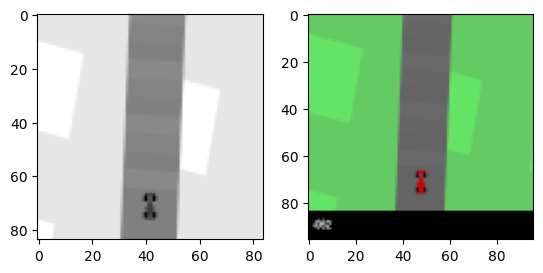

In [ ]:
plt.imshow(image)